In [5]:
pip install nltk


In [6]:
pip install transformers


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import GPT2Tokenizer, TFGPT2Model
from tensorflow.keras import Model, layers
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

warnings.filterwarnings("ignore")

In [8]:
df = pd.read_json('News_Category_Dataset_v3.json', lines=True)
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [9]:
category_counts = df['category'].value_counts()
print(category_counts)

category
POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3653
WOMEN              3572
CRIME              3562
IMPACT             3484
DIVORCE            3426
WORLD NEWS         3299
MEDIA              2944
WEIRD NEWS         2777
GREEN              2622
WORLDPOST          2579
RELIGION           2577
STYLE              2254
SCIENCE            2206
TECH               2104
TASTE              2096
MONEY              1756
ARTS               1509
ENVIRONMENT        1444
FIFTY              1401
GOOD NEWS          1398
U.S. NEWS          1377
ARTS & CULTURE     1339
COLLEGE            1144
LATINO VOICES      1130
CULTURE & ARTS     1074
EDUCATI

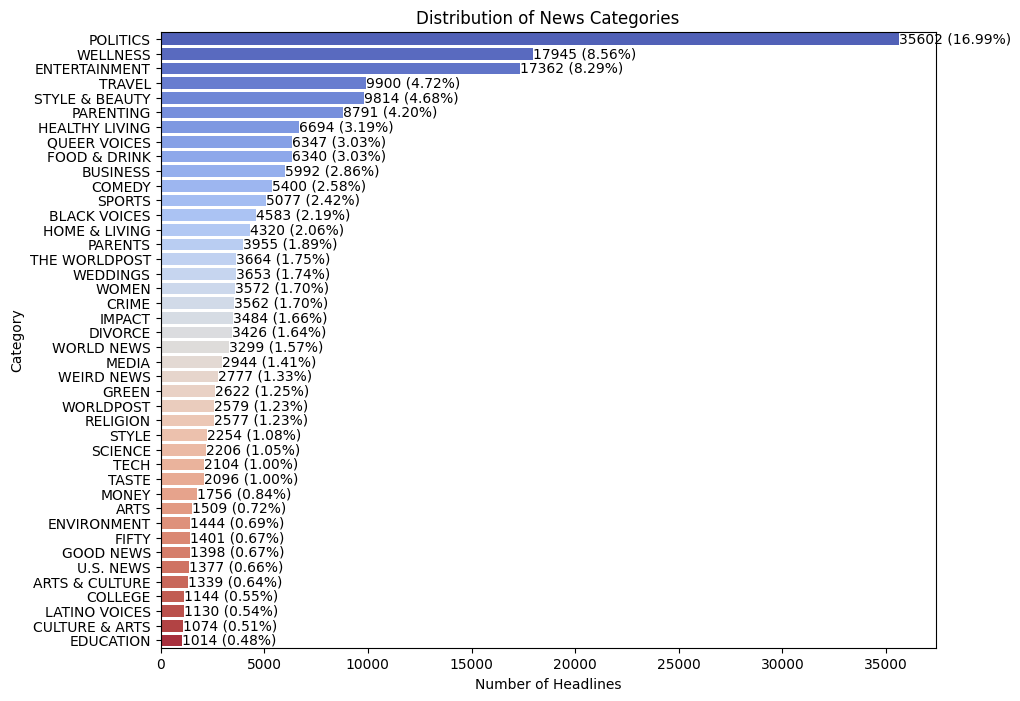

In [10]:
category_counts = df['category'].value_counts()
total = len(df)
plt.figure(figsize=(10, 8))
sns.barplot(x=category_counts.values, y=category_counts.index, palette="coolwarm")
for i, value in enumerate(category_counts.values):
    plt.text(value, i, f'{value} ({(value / total) * 100:.2f}%)', va='center')

plt.title('Distribution of News Categories')
plt.xlabel('Number of Headlines')
plt.ylabel('Category')
plt.show()

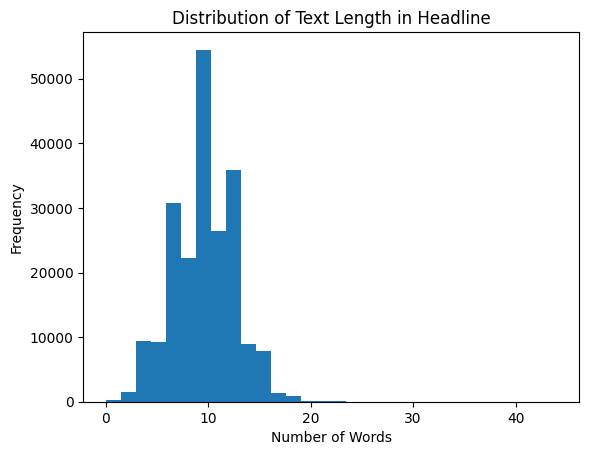

In [17]:
df['text_length'] = df['headline'].apply(lambda x: len(x.split()))
plt.hist(df['text_length'], bins=30)
plt.title('Distribution of Text Length in Headline')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [18]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

In [20]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [21]:
df['cleaned_text'] = df['headline'] + " " + df['short_description']
df['cleaned_text'] = df['cleaned_text'].apply(clean_text)

In [22]:
missing_values = df.isnull().sum()
print("Missing Values:", missing_values)
df = df.dropna()
df = df.drop_duplicates(subset='headline')

Missing Values: link                 0
headline             0
category             0
short_description    0
authors              0
date                 0
text_length          0
cleaned_text         0
dtype: int64


In [23]:
# Resample data
from sklearn.utils import resample
target_size = 18000
resampled_dfs = []

for category in df['category'].unique():
    df_category = df[df['category'] == category]

    if len(df_category) < target_size:
        df_category_upsampled = resample(df_category, replace=True, n_samples=target_size, random_state=42)
        resampled_dfs.append(df_category_upsampled)
    else:
        df_category_downsampled = resample(df_category, replace=False, n_samples=target_size, random_state=42)
        resampled_dfs.append(df_category_downsampled)


In [24]:
df_resampled = pd.concat(resampled_dfs, ignore_index=True)
print("Columns in resampled DataFrame:", df_resampled.columns)


Columns in resampled DataFrame: Index(['link', 'headline', 'category', 'short_description', 'authors', 'date',
       'text_length', 'cleaned_text'],
      dtype='object')


In [25]:
print(df_resampled['category'].value_counts())

category
U.S. NEWS         18000
ARTS & CULTURE    18000
TRAVEL            18000
MONEY             18000
RELIGION          18000
LATINO VOICES     18000
IMPACT            18000
WEDDINGS          18000
COLLEGE           18000
PARENTS           18000
STYLE             18000
COMEDY            18000
GREEN             18000
TASTE             18000
HEALTHY LIVING    18000
THE WORLDPOST     18000
GOOD NEWS         18000
WORLDPOST         18000
FIFTY             18000
ARTS              18000
BLACK VOICES      18000
WOMEN             18000
HOME & LIVING     18000
QUEER VOICES      18000
PARENTING         18000
WORLD NEWS        18000
CULTURE & ARTS    18000
TECH              18000
SPORTS            18000
ENTERTAINMENT     18000
POLITICS          18000
WEIRD NEWS        18000
ENVIRONMENT       18000
EDUCATION         18000
CRIME             18000
SCIENCE           18000
WELLNESS          18000
BUSINESS          18000
STYLE & BEAUTY    18000
FOOD & DRINK      18000
MEDIA             18000
DIVORCE

In [26]:
df_resampled['text_length'] = df_resampled['cleaned_text'].apply(lambda x: len(x.split()))

In [27]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df_resampled['cleaned_text'])
sequences = tokenizer.texts_to_sequences(df_resampled['cleaned_text'])
padded_sequences = pad_sequences(sequences, maxlen=50, padding='post')

In [28]:
le = LabelEncoder()
df_resampled['category_encoded'] = le.fit_transform(df_resampled['category'])
labels = df_resampled['category_encoded']

In [29]:
print(f"Padded Sequences Shape: {padded_sequences.shape}")
print(f"Labels Shape: {labels.shape}")


Padded Sequences Shape: (756000, 50)
Labels Shape: (756000,)


In [30]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, stratify=labels, random_state=42)


In [31]:
pip install keras-tuner --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 11.4 MB/s eta 0:00:00


**1 - BiLSTM MODEL**

In [ ]:
import kerastuner as kt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Assuming you've prepared your data and tokenizer
# These are the parameters you need to define
vocab_size = 10000  # Number of words in your vocabulary
embedding_dim = 100  # Dimensionality of the word embeddings
input_length = 50  # Max length of input sequences (as used in padding)
num_classes = 42  # Number of output categories (adjust as per your dataset)



In [ ]:
# Define a function for hyperparameter tuning
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length))

    # Tune the number of LSTM units
    lstm_units = hp.Int('lstm_units', min_value=64, max_value=256, step=64)
    model.add(Bidirectional(LSTM(units=lstm_units, return_sequences=False)))

    # Tune the dropout rate
    dropout_rate = hp.Float('dropout_rate', min_value=0.3, max_value=0.5, step=0.1)
    model.add(Dropout(dropout_rate))

    model.add(Dense(num_classes, activation='softmax'))

    # Tune the learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model



In [ ]:
# Set up Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Try 5 different combinations of hyperparameters
    executions_per_trial=2,  # Train each model 2 times
    directory='my_dir',
    project_name='bilstm_tuning')

# Assuming `padded_sequences` is your input data and `labels` is your output data
# Split the sample data
X_sample, X_rest, y_sample, y_rest = train_test_split(padded_sequences, labels, test_size=0.8, stratify=labels, random_state=42)

# Run the tuner search
tuner.search(X_sample, y_sample, epochs=5, validation_split=0.2)

# Get the best hyperparameters


Trial 5 Complete [00h 06m 56s]
val_accuracy: 0.5446924865245819

Best val_accuracy So Far: 0.735962301492691
Total elapsed time: 00h 35m 37s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best LSTM units: {best_hps.get('lstm_units')}")
print(f"Best Dropout rate: {best_hps.get('dropout_rate')}")
print(f"Best Learning rate: {best_hps.get('learning_rate')}")

# Build the best model
best_model = tuner.hypermodel.build(best_hps)

# Now split the full dataset into training and testing sets for final model training
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, stratify=labels, random_state=42)

# Train the final model with the best hyperparameters on the full dataset
history = best_model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test))

# Evaluate the model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")


Best LSTM units: 192
Best Dropout rate: 0.3
Best Learning rate: 0.001
Epoch 1/10
9450/9450 ━━━━━━━━━━━━━━━━━━━━ 105s 11ms/step - accuracy: 0.4792 - loss: 1.8883 - val_accuracy: 0.7500 - val_loss: 0.8696
Epoch 2/10
9450/9450 ━━━━━━━━━━━━━━━━━━━━ 101s 11ms/step - accuracy: 0.7820 - loss: 0.7578 - val_accuracy: 0.8372 - val_loss: 0.5769
Epoch 3/10
9450/9450 ━━━━━━━━━━━━━━━━━━━━ 143s 11ms/step - accuracy: 0.8594 - loss: 0.4877 - val_accuracy: 0.8841 - val_loss: 0.4310
Epoch 4/10
9450/9450 ━━━━━━━━━━━━━━━━━━━━ 101s 11ms/step - accuracy: 0.9007 - loss: 0.3442 - val_accuracy: 0.9050 - val_loss: 0.3599
Epoch 5/10
9450/9450 ━━━━━━━━━━━━━━━━━━━━ 142s 11ms/step - accuracy: 0.9249 - loss: 0.2613 - val_accuracy: 0.9230 - val_loss: 0.3064
Epoch 6/10
9450/9450 ━━━━━━━━━━━━━━━━━━━━ 142s 11ms/step - accuracy: 0.9402 - loss: 0.2078 - val_accuracy: 0.9330 - val_loss: 0.2789
Epoch 7/10
9450/9450 ━━━━━━━━━━━━━━━━━━━━ 146s 11ms/step - accuracy: 0.9505 - loss: 0.1714 - val_accuracy: 0.9398 - val_loss: 0.2621

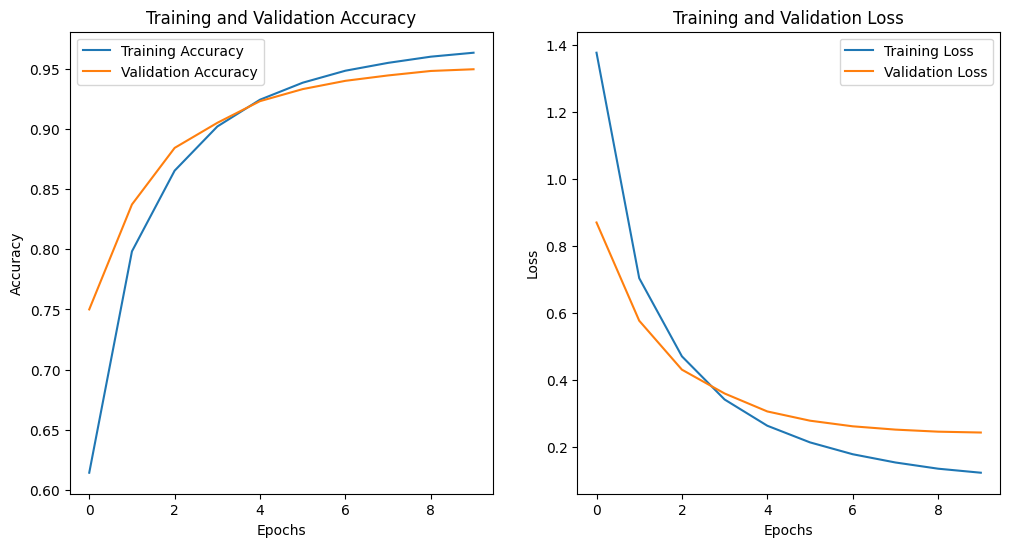

In [ ]:
import matplotlib.pyplot as plt



# Accuracy plot
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


4725/4725 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3600
           1       0.98      1.00      0.99      3600
           2       0.93      0.93      0.93      3600
           3       0.92      0.89      0.91      3600
           4       0.99      1.00      0.99      3600
           5       0.91      0.89      0.90      3600
           6       0.96      0.98      0.97      3600
           7       0.99      1.00      0.99      3600
           8       0.98      0.98      0.98      3600
           9       0.99      1.00      0.99      3600
          10       0.87      0.78      0.82      3600
          11       0.97      1.00      0.99      3600
          12       0.97      0.99      0.98      3600
          13       0.94      0.94      0.94      3600
          14       0.98      1.00      0.99      3600
          15       0.96      0.99      0.97      3600
          16  

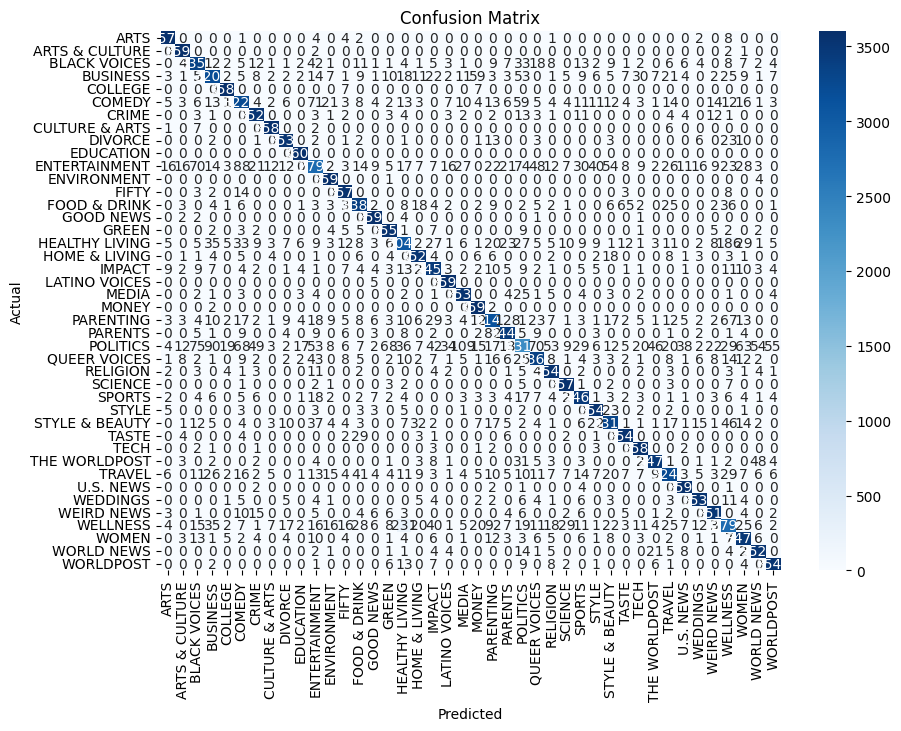

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions on the test set
y_pred = best_model.predict(X_test)
y_pred_classes = tf.argmax(y_pred, axis=1)  # Get the class with the highest predicted probability

# Calculate precision and recall
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Optional: Print confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
best_model.save('bilstm_category_classification_model.h5')

**2 - cnn+lstm MODEL**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Define the CNN-LSTM model
def create_model(vocab_size, embedding_dim, input_length):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=input_length))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(100))
    model.add(Dropout(0.5))
    model.add(Dense(len(le.classes_), activation='softmax'))  # Output layer for multi-class classification
    return model



In [ ]:
# Set parameters
vocab_size = 10000  # Same as defined in the tokenizer
embedding_dim = 128
input_length = 50   # Same as the maxlen in pad_sequences

# Create the model
model = create_model(vocab_size, embedding_dim, input_length)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fit the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=10,
                    batch_size=64,
                    callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')


Epoch 1/10
7560/7560 ━━━━━━━━━━━━━━━━━━━━ 58s 7ms/step - accuracy: 0.2975 - loss: 2.5810 - val_accuracy: 0.6999 - val_loss: 1.0815
Epoch 2/10
7560/7560 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - accuracy: 0.7496 - loss: 0.9310 - val_accuracy: 0.8167 - val_loss: 0.6821
Epoch 3/10
7560/7560 ━━━━━━━━━━━━━━━━━━━━ 85s 8ms/step - accuracy: 0.8577 - loss: 0.5418 - val_accuracy: 0.8688 - val_loss: 0.5190
Epoch 4/10
7560/7560 ━━━━━━━━━━━━━━━━━━━━ 63s 8ms/step - accuracy: 0.9062 - loss: 0.3685 - val_accuracy: 0.8907 - val_loss: 0.4463
Epoch 5/10
7560/7560 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - accuracy: 0.9300 - loss: 0.2805 - val_accuracy: 0.8975 - val_loss: 0.4191
Epoch 6/10
7560/7560 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - accuracy: 0.9441 - loss: 0.2239 - val_accuracy: 0.9134 - val_loss: 0.3828
Epoch 7/10
7560/7560 ━━━━━━━━━━━━━━━━━━━━ 84s 9ms/step - accuracy: 0.9530 - loss: 0.1902 - val_accuracy: 0.9192 - val_loss: 0.3768
Epoch 8/10
7560/7560 ━━━━━━━━━━━━━━━━━━━━ 82s 9ms/step - accuracy: 0.9593 - loss: 0

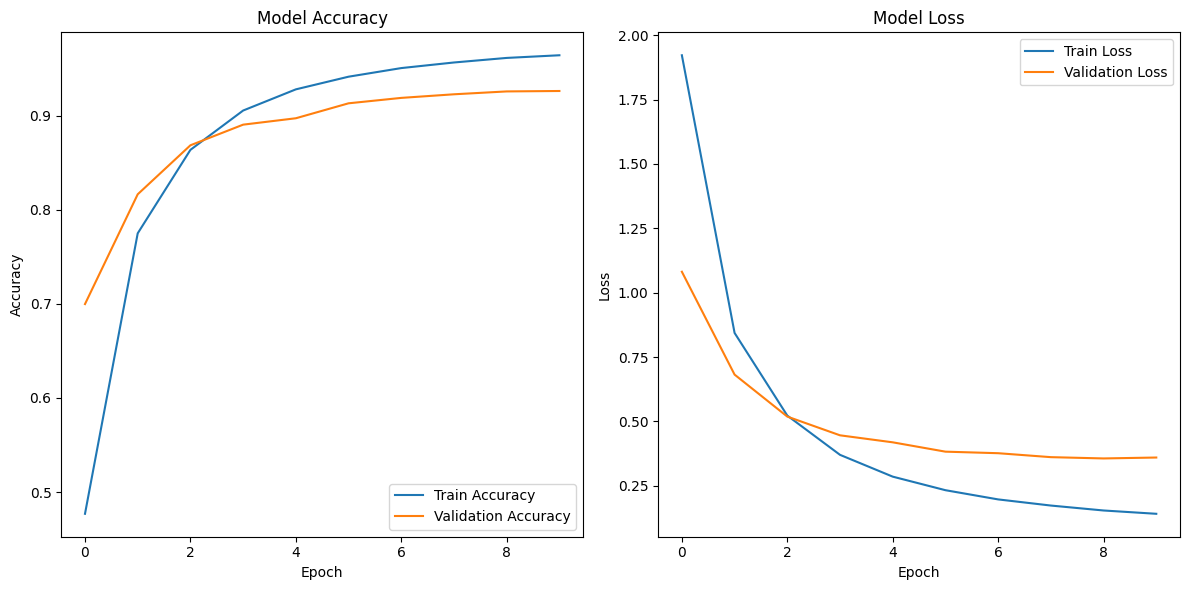

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


4725/4725 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3600
           1       0.98      0.99      0.98      3600
           2       0.85      0.92      0.88      3600
           3       0.88      0.87      0.87      3600
           4       0.98      0.99      0.99      3600
           5       0.87      0.86      0.87      3600
           6       0.96      0.96      0.96      3600
           7       0.98      1.00      0.99      3600
           8       0.95      0.97      0.96      3600
           9       0.98      1.00      0.99      3600
          10       0.82      0.68      0.75      3600
          11       0.98      0.99      0.98      3600
          12       0.96      0.99      0.97      3600
          13       0.92      0.90      0.91      3600
          14       0.97      0.98      0.98      3600
          15       0.95      0.97      0.96      3600
          16  

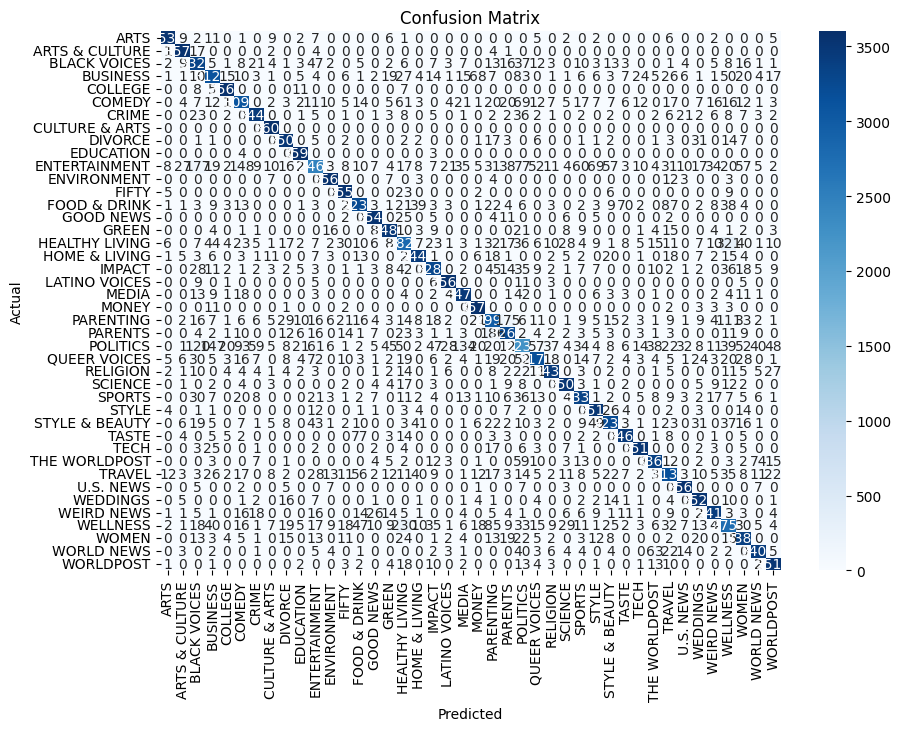

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = tf.argmax(y_pred, axis=1)  # Get the predicted class indices

# Calculate precision and recall
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Optional: Print confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
# Save the model
model.save('cnn_lstm_classification_model.h5')


In [ ]:
!pip install transformers
!pip install keras-tuner --upgrade


**3** - **gpt** **model**

In [ ]:
from transformers import GPT2Tokenizer, TFGPT2Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.mixed_precision import set_global_policy



# Set mixed precision policy
set_global_policy('mixed_float16')


# Load the GPT-2 tokenizer
gpt_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt_tokenizer.pad_token = gpt_tokenizer.eos_token  # Set padding token to EOS


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060, compute capability 8.6


2024-10-23 14:53:14.987453: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-23 14:53:15.002764: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-23 14:53:15.002901: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [ ]:
def encode_texts(texts, max_length=30):
    encodings = gpt_tokenizer(texts.tolist(), max_length=max_length, padding='max_length', truncation=True, return_tensors='tf')
    return encodings['input_ids'], encodings['attention_mask']


In [ ]:
# Prepare your dataset
X_gpt_input_ids, X_gpt_attention_masks = encode_texts(df_resampled['cleaned_text'], max_length=25)
le = LabelEncoder()
df_resampled['category_encoded'] = le.fit_transform(df_resampled['category'])
labels = df_resampled['category_encoded'].values

2024-10-23 14:54:01.700288: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-23 14:54:01.700428: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-23 14:54:01.700494: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [ ]:
# Split the dataset
X_train_ids, X_test_ids, X_train_masks, X_test_masks, y_train, y_test = train_test_split(
    X_gpt_input_ids.numpy(),
    X_gpt_attention_masks.numpy(),
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

In [ ]:
class GPT2Classifier(Model):
    def __init__(self, num_classes):
        super(GPT2Classifier, self).__init__()
        self.gpt2 = TFGPT2Model.from_pretrained('gpt2')
        self.dense = layers.Dense(num_classes, activation='softmax', dtype='float32')  # Ensure output is float32

    def call(self, inputs):
        input_ids, attention_mask = inputs
        gpt2_output = self.gpt2(input_ids, attention_mask=attention_mask)[0]
        pooled_output = gpt2_output[:, -1, :]
        return self.dense(pooled_output)

num_classes = len(le.classes_)
model = GPT2Classifier(num_classes)


All PyTorch model weights were used when initializing TFGPT2Model.

All the weights of TFGPT2Model were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [ ]:
# Compile the model with Adam optimizer and the learning rate of 1e-5
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Create a TensorFlow Dataset
# Create the TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(((X_train_ids, X_train_masks), y_train))

# Shuffle, batch, and prefetch the dataset for better performance
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64).prefetch(tf.data.experimental.AUTOTUNE)

# Add EarlyStopping and Learning Rate Scheduler callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)


In [ ]:
# Split the data into training and validation sets manually
X_train_ids_split, X_val_ids, X_train_masks_split, X_val_masks, y_train_split, y_val = train_test_split(
    X_train_ids,
    X_train_masks,
    y_train,
    test_size=0.2,  # 20% of data will be used for validation
    stratify=y_train,
    random_state=42
)

# Create TensorFlow Dataset for training
train_dataset = tf.data.Dataset.from_tensor_slices(((X_train_ids_split, X_train_masks_split), y_train_split))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64).prefetch(tf.data.experimental.AUTOTUNE)

# Create TensorFlow Dataset for validation
val_dataset = tf.data.Dataset.from_tensor_slices(((X_val_ids, X_val_masks), y_val))
val_dataset = val_dataset.batch(64).prefetch(tf.data.experimental.AUTOTUNE)


In [ ]:

history = model.fit(
    train_dataset,
    epochs=3,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/3
7560/7560 [==============================] - 1386s 183ms/step - loss: 1.5305 - accuracy: 0.5672 - lr: 1.0000e-05
Epoch 2/3
7560/7560 [==============================] - 1380s 183ms/step - loss: 0.5131 - accuracy: 0.8590 - lr: 1.0000e-05
Epoch 3/3
7560/7560 [==============================] - 1381s 183ms/step - loss: 0.1554 - accuracy: 0.9603 - lr: 1.0000e-05


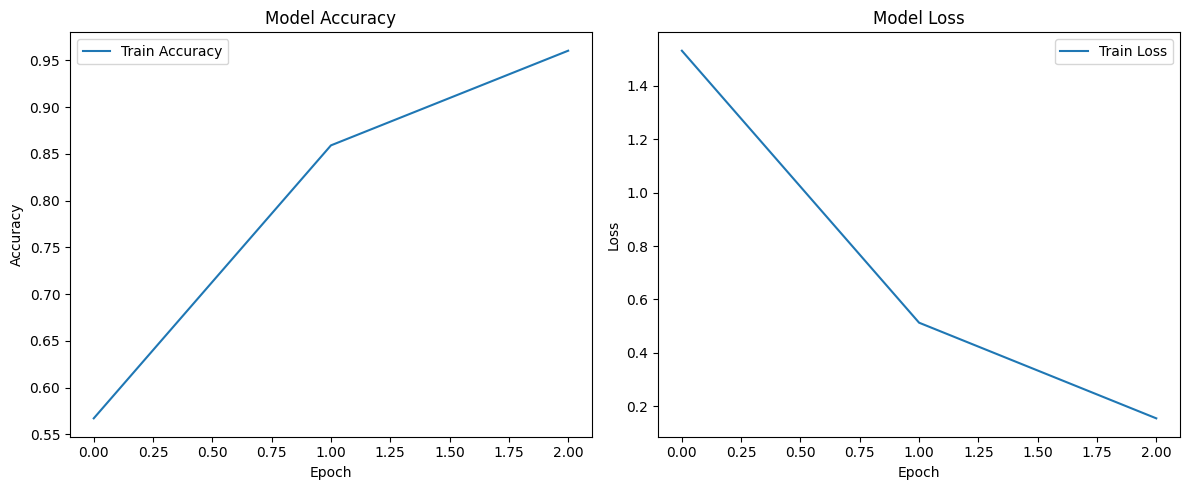

In [ ]:

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
y_pred = model.predict([X_test_ids, X_test_masks])
y_pred_classes = tf.argmax(y_pred, axis=1).numpy()


4725/4725 [==============================] - 160s 33ms/step


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))

                precision    recall  f1-score   support

          ARTS       0.98      1.00      0.99      3600
ARTS & CULTURE       0.98      1.00      0.99      3600
  BLACK VOICES       0.91      0.91      0.91      3600
      BUSINESS       0.93      0.86      0.89      3600
       COLLEGE       0.99      1.00      0.99      3600
        COMEDY       0.88      0.92      0.90      3600
         CRIME       0.95      0.97      0.96      3600
CULTURE & ARTS       0.99      1.00      0.99      3600
       DIVORCE       0.97      0.97      0.97      3600
     EDUCATION       0.99      1.00      0.99      3600
 ENTERTAINMENT       0.82      0.76      0.79      3600
   ENVIRONMENT       0.99      0.99      0.99      3600
         FIFTY       0.97      1.00      0.99      3600
  FOOD & DRINK       0.95      0.91      0.93      3600
     GOOD NEWS       0.99      1.00      0.99      3600
         GREEN       0.94      0.99      0.96      3600
HEALTHY LIVING       0.85      0.83      0.84  

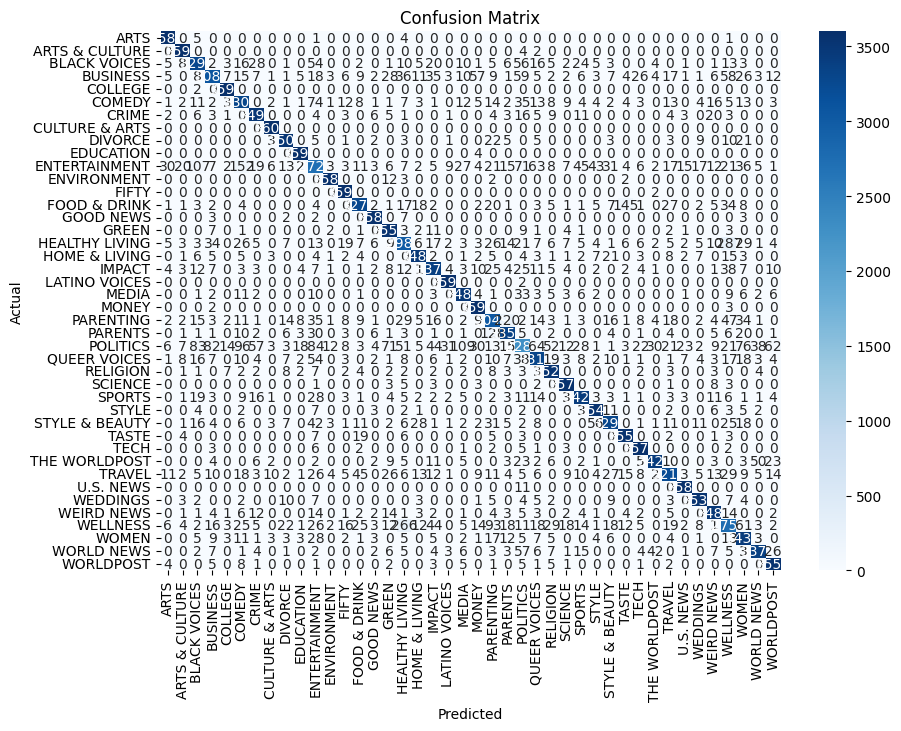

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


**4 - LSTM MODEL**

In [43]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=50),
    LSTM(128, return_sequences=True),
    Dropout(0.5),
    BatchNormalization(),
    LSTM(64),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(len(le.classes_), activation='softmax')
])


In [35]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [36]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

In [38]:
history = model.fit(X_train,
                    y_train,
                    validation_split=0.2,
                    epochs=5,
                    batch_size=32,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/5
15120/15120 ━━━━━━━━━━━━━━━━━━━━ 188s 12ms/step - accuracy: 0.1597 - loss: 3.1343 - val_accuracy: 0.5944 - val_loss: 1.4719 - learning_rate: 0.0010
Epoch 2/5
15120/15120 ━━━━━━━━━━━━━━━━━━━━ 192s 12ms/step - accuracy: 0.6145 - loss: 1.4474 - val_accuracy: 0.7255 - val_loss: 1.0320 - learning_rate: 0.0010
Epoch 3/5
15120/15120 ━━━━━━━━━━━━━━━━━━━━ 202s 12ms/step - accuracy: 0.7423 - loss: 0.9967 - val_accuracy: 0.7844 - val_loss: 0.8325 - learning_rate: 0.0010
Epoch 4/5
15120/15120 ━━━━━━━━━━━━━━━━━━━━ 196s 11ms/step - accuracy: 0.8115 - loss: 0.7442 - val_accuracy: 0.8287 - val_loss: 0.6969 - learning_rate: 0.0010
Epoch 5/5
15120/15120 ━━━━━━━━━━━━━━━━━━━━ 208s 12ms/step - accuracy: 0.8556 - loss: 0.5839 - val_accuracy: 0.8472 - val_loss: 0.6351 - learning_rate: 0.0010


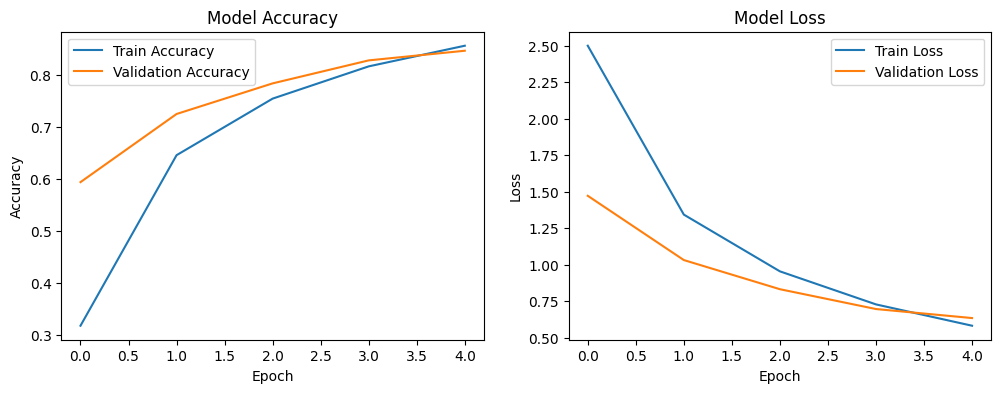

In [39]:
import matplotlib.pyplot as plt

# Plotting accuracy
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()


In [40]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

cm = confusion_matrix(y_test, y_pred_classes)
report = classification_report(y_test, y_pred_classes, target_names=le.classes_)

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)


4725/4725 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step
Confusion Matrix:
[[3558    5    0 ...    0    0    2]
 [   8 3539    0 ...    3    3    0]
 [   5   11 2663 ...   80    6    5]
 ...
 [   6   15   30 ... 2867    6    1]
 [   0    5    4 ...    5 3143    6]
 [  14    0    1 ...    1   30 3274]]

Classification Report:
                precision    recall  f1-score   support

          ARTS       0.91      0.99      0.95      3600
ARTS & CULTURE       0.93      0.98      0.96      3600
  BLACK VOICES       0.81      0.74      0.77      3600
      BUSINESS       0.78      0.69      0.74      3600
       COLLEGE       0.95      0.98      0.97      3600
        COMEDY       0.73      0.70      0.71      3600
         CRIME       0.83      0.91      0.86      3600
CULTURE & ARTS       0.96      0.99      0.97      3600
       DIVORCE       0.92      0.93      0.92      3600
     EDUCATION       0.95      0.99      0.97      3600
 ENTERTAINMENT       0.70      0.52      0.59      3600
   ENVIRONMEN

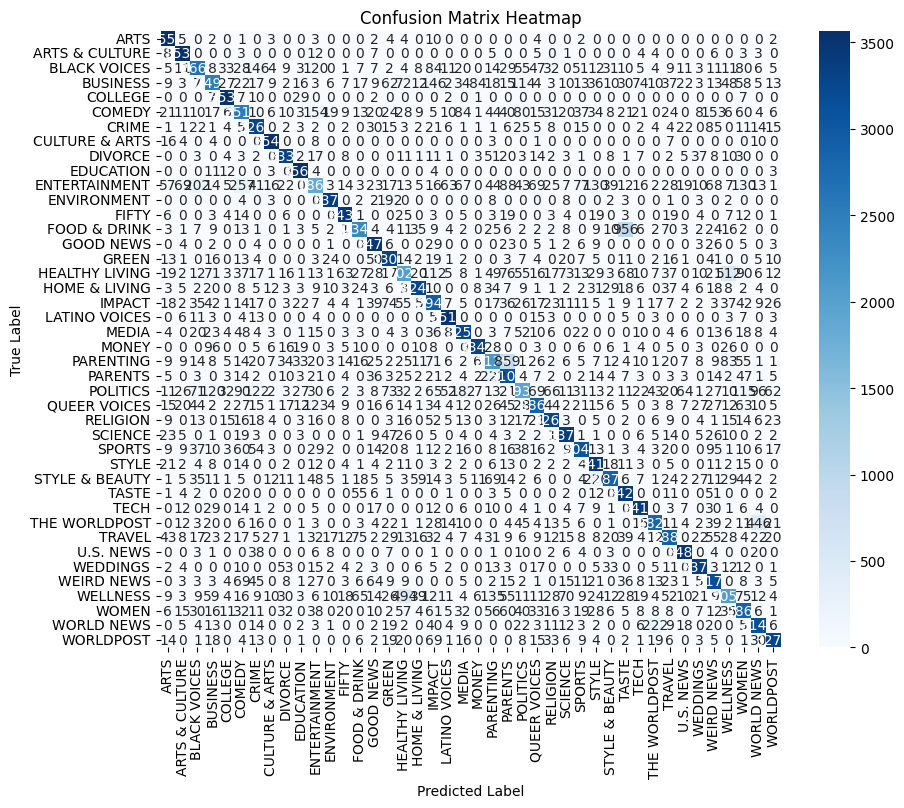

In [41]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix Heatmap')
plt.show()